# The Quadratic Unconstrained Binary Optimization (QUBO)

*Author: Alejandro Montanez — Posted: August 2023.*

Solving combinatorial optimization problems using quantum computing is one of those promising applications for the near term. But, why are combinatorial optimization problems even important? well, we care about them because we have useful applications that can be translated into combinatorial optimization problems, in fields such as logistics, finance, and engineering. But having useful applications is not enough, and it is here where the second ingredient comes in, many combinatorial optimization problems are difficult to solve! and finding good solutions (classically) for large instances of them requires an enormous amount of computational resources and time 😮‍💨. 

In this demo, we will be using a quantum algorithm called the Quantum Approximate Optimization Algorithm (QAOA) to solve a combinatorial optimization problem. First, we show how to translate combinatorial optimization problems into the quadratic unconstrained binary optimization (QUBO) formulation. In the first part of this notebook, we will show how to encode the Knapsack problem as a target Hamiltonian and solve it using QAOA. The second part is given to you as an exercise to repeat the process but for the Maximal independent set (MIS).

# <a class="anchor" id="qubo"> </a>1. Generalities: Combinatorial Optimization Problems

Combinatorial optimization problems are a type of mathematical problem that involves finding the best way to arrange a set of objects or values to achieve a specific goal. The word 'combinatorial' refers to the fact that we are dealing with combinations of objects, while 'optimization' refers to the fact that we are trying to find the best possible arrangement of them.

Let's start with a basic example. Imagine we have 5 items ⚽️, 💻, 📸, 📚, and 🎸 and we would love to bring all of them with us. But to our bad luck, we only have a knapsack and do not have space for all of them 😔. So, we need to find the best way to bring the most important items for us. 

But, to start our problem formulation, we need more information. From our problem statement, we know that we need to maximize the value of the most important items. So we need to assign a value based on the importance the items have to us:

In [1]:
items_values = {"⚽️":3, "💻":3, "📸":1, "📚":1, "🎸":5 }

Additionally, we know that we are restricted for the space in the Knapsack, for simplification let's assume the restriction is in terms of weight. So we need to assign an estimate of the weight of each item:

In [2]:
items_weight = {"⚽️":2, "💻":4, "📸":1, "📚":3, "🎸":5 }

Finally, we need to know the maximum weight we can bring in the knapsack:

In [3]:
maximum_weight = 7

Ok, now that we have a problem to work with. Let's start with the easiest way to solve it, i.e., trying all possible combinations of those items which we find to grow as $2^n$ where $n$ is the number of items. Why does it grow in that way? because for each item we have two options "1" if we bring the item and "0" otherwise. So 2 options for each item, and we have 5 items then $2*2*2*2*2 = 2^5 = 32$ combinations in our case. For each of these cases, we calculate the sum of the values and the sum weights, selecting the one that fulfills the maximum weight constraint and has the largest values' sum (the optimization step).

In [4]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

items = list(items_values.keys())
n = len(items)
combinations = {}
max_value = 0 
for case_i in range(2**n):
    bitstring = np.binary_repr(case_i, n) #bitstring representation of a case, e.g, "01100" in our problem means bringing (-💻📸--)
    combinations[case_i] = {"items":[], "value":0, "weight":0}
    for item_i, bring in enumerate(bitstring):
         if bring == "1":
            combinations[case_i]["items"].append(items[item_i])
            combinations[case_i]["value"] += items_values[items[item_i]]
            combinations[case_i]["weight"] += items_weight[items[item_i]]
    if combinations[case_i]["value"] > max_value and combinations[case_i]["weight"] <= maximum_weight:
        max_value = combinations[case_i]["value"]
        optimal_solution = {"items": combinations[case_i]["items"],
                           "value": combinations[case_i]["value"],
                           "weight":combinations[case_i]["weight"]}
pd.DataFrame(combinations)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
items,[],[🎸],[📚],"[📚, 🎸]",[📸],"[📸, 🎸]","[📸, 📚]","[📸, 📚, 🎸]",[💻],"[💻, 🎸]",...,"[⚽️, 📸, 📚]","[⚽️, 📸, 📚, 🎸]","[⚽️, 💻]","[⚽️, 💻, 🎸]","[⚽️, 💻, 📚]","[⚽️, 💻, 📚, 🎸]","[⚽️, 💻, 📸]","[⚽️, 💻, 📸, 🎸]","[⚽️, 💻, 📸, 📚]","[⚽️, 💻, 📸, 📚, 🎸]"
value,0,5,1,6,1,6,2,7,3,8,...,5,10,6,11,7,12,7,12,8,13
weight,0,5,3,8,1,6,4,9,4,9,...,6,11,6,11,9,14,7,12,10,15


In [5]:
print(f"The best combination is {optimal_solution['items']} with a total value: {optimal_solution['value']} and total weight {optimal_solution['weight']} ")

The best combination is ['⚽️', '🎸'] with a total value: 8 and total weight 7 


That was easy, right? But what about if we have larger cases like 10, 50, or 100? Just to play around with these numbers suppose we spend 1 ns to try one case.

In [6]:
print(f"- For 10 items, 2^10 cases, we need {2**10*1e-9} seconds to solve the problem\n- For 50 items, 2^50 cases, we need:{round((2**50*1e-9)/(3600*24))} days \n- For 100 items, 2^100 cases, we need: {round((2**100*1e-9)/(3600*24*365))} years")

- For 10 items, 2^10 cases, we need 1.024e-06 seconds to solve the problem
- For 50 items, 2^50 cases, we need:13 days 
- For 100 items, 2^100 cases, we need: 40196936841331 years


I guess we don't have the time to try all possible solutions for 100 items 😅! Thankfully, we don't need to try all of them and there are algorithms to find good solutions to combinatorial optimization problems, and maybe one day we will show that one of these algorithms is quantum. So let's continue with our quest 🫡. 

Our next step is to represent our problem mathematically. Well, we know what we want, **maximize** the value of the items transported, so let's create a function $f(\mathrm{x})$ with these characteristics. To do so, assign to the items, the variables $x_i$ for each of them $\mathrm{x} = \{x_0:"⚽️", x_1:"💻", x_2:"📸", x_3:"📚", x_4:"🎸"\}$ and multiply such variable for the value of the item, items_value = {"⚽️":3, "💻":3, "📸":1, "📚":1, "🎸":5 }.

$$\max_x f(\mathrm{x}) = 3x_0 + 3x_1 + x_2 + x_3 + 5x_4 \tag{1}$$

This function, called the `objective function`, clearly represents the value of the items we can transport. Usually, solvers minimize functions, so a simple trick in our case is to minimize the negative of our function (which ends up maximizing our original function 🤪)

$$\min_x f(\mathrm{x}) = -(3x_0 + 3x_1 + x_2 + x_3 + 5x_4) \tag{2}$$


We will use `sympy` a python based library that allows us to work using symbolic expressions.

In [7]:
from sympy import Symbol

x = {items[i]: Symbol(f"x{i}") for i in range(n)}  # variables that represent the items
fx = 0
for i in range(n):
    fx -= items_values[items[i]] * x[items[i]]
print("f(x) =", fx)

f(x) = -3*x0 - 3*x1 - x2 - x3 - 5*x4


But just with this function, we cannot solve the problem. We also need weight restriction. Based on our variables, the weight list (items_weight = {"⚽️":2, "💻":4, "📸":1, "📚":3, "🎸":5 }), and the knapsack maximum weight (maximum_weight $W = 7$), we can construct our restriction 

$$2x_0 + 4x_1 + x_2 + x_3 + 5x_4 \le 7 \tag{3}$$

Now, here is an important part of our model, we need to find a way to combine our `objective function` with this `inequality constraint`. One common method is to include the constraint as a **penalization** term in the objective function. This penalization term should be zero when the total weight of the items is less or equal to 7 and large otherwise. So to make them zero in the range of validity of the constraint, the usual approach is to use `slack variables` (an alternative method [here](https://arxiv.org/pdf/2211.13914.pdf) 😉). 

The slack variable is an auxiliary variable to convert inequality constraints into equality constraints. The slack variable $S$ represents the amount by which the left-hand side of the inequality falls short of the right-hand side. If the left-hand side is less than the right-hand side, then $S$ will be positive and equal to the difference between the two sides. In our case

$$2x_0 + 4x_1 + x_2 + x_3 + 5x_4 + S = 7 \tag{4}$$

for $0 \le S \le 7$. But let's take this slowly because we can get lost here, so let's see this with some examples...

- Imagine this case, no item is selected {$x_0$:0, $x_1$:0, $x_2$:0, $x_3$:0, $x_4$:0}, so the overall weight is zero (a valid solution) and the equality constraint Eq.(4) must be fulfilled. So we select our slack variable to be 7.


- Now, what if we bring the ⚽️, 📸, 📚 {$x_0$:1, $x_1$:0, $x_2$:1, $x_3$:1, $x_4$:0} so the overall weight is 2 + 1 + 1=4 (a valid solution) and to make the equality constraint right S=3.


- Finally, what if we try to bring all the items {$x_0$:1, $x_1$:1, $x_2$:1, $x_3$:1, $x_4$:1}, the total weight, in this case, is 2+4+1+3+5=15 (not a valid solution), to fulfill the constraint, we need $S = -7$ but the slack variable is in the range $[0,7]$ in our definition, so, in this case, there is no way to represent the right-hand side in our equation.

Excellent, now we have a way to represent the inequality constraint. Two further steps are needed, first, the slack variable has to be represented in binary form so we can transform it by 

$$S = \sum_{k=0}^{N-1} 2^k s_k$$

where $N = \lfloor\log_2(\max S)\rfloor + 1$. In our case $N = \lfloor\log_2(7)\rfloor + 1  = 3$. We need three binary variables to represent the range of our $S$ variable.

$$S = 2^0 s_0 + 2^1 s_1 + 2^2 s_2 = s_0 + 2s_1 + 4s_2 $$

For example, if we need to represent the second case above (⚽️, 📸, 📚) $S=3\rightarrow\{s_0:1, s_1:1,s_2:0\}$.


We are almost done in our quest to represent our problem in such a way that our quantum computer can manage it. The last step is to add the penalization term, a usual choice for it is to use a quadratic penalization

$$p(x,s) = \lambda \left(2x_0 + 4x_1 + x_2 + x_3 + 5x_4 + s_0 + 2 s_1 + 4s_2 - 7\right)^2 \tag{5}$$

note that this is the same Eq.(4) just the left-hand side less the right-hand side here. With this expression just when the condition is satisfied the term inside the parenthesis is zero. $\lambda$ is a penalization coefficient that we must tune to make that the constraint will be always fulfilled. 

Now, the objective function can be given by:

$$\min_{x,s} f(x) + p(x,s) = -(3x_0 + 3x_1 + x_2 + x_3 + 5x_4) + \lambda \left(2x_0 + 4x_1 + x_2 + x_3 + 5x_4 + s_0 + 2 s_1 + 4s_2 - 7\right)^2 \tag{6}$$

or compacted:

$$\min_{x,s} f(x) + p(x,s) = -\sum_i v_i x_i +\lambda \left(\sum_i w_i x_i + \sum_{k=0}^{N-1} 2^k s_k - W\right)^2\tag{7}$$

where $v_i$ and $w_i$ are the value and weight of the $i^{th}$ item. Because of the square in the second term, $x_i x_i$ terms show up, we can apply the property $x_i x_i = x_i$ (if $x_i = 0$, $x_ix_i = 0*0 = 0$ or $x_i = 1$, $x_ix_i = 1*1 = 1$). 

In [8]:
N = round(np.ceil(np.log2(maximum_weight)))
slack = {f"s{k}":Symbol(f"s{k}") for k in range(N)}
Lambda = Symbol(r"\lambda")
p = 0
for i in range(n):
    p += items_weight[items[i]] * x[items[i]]
for k in range(N):
    p += 2**k * slack[f"s{k}"]
p -= maximum_weight
p = p**2
print("p(x,s) =", p)
p = Lambda * p.expand().subs({symbol**2:symbol for symbol in p.free_symbols}) # applying the property x_i = x_i*x_i
p

p(x,s) = (s0 + 2*s1 + 4*s2 + 2*x0 + 4*x1 + x2 + 3*x3 + 5*x4 - 7)**2


\lambda*(4*s0*s1 + 8*s0*s2 + 4*s0*x0 + 8*s0*x1 + 2*s0*x2 + 6*s0*x3 + 10*s0*x4 - 13*s0 + 16*s1*s2 + 8*s1*x0 + 16*s1*x1 + 4*s1*x2 + 12*s1*x3 + 20*s1*x4 - 24*s1 + 16*s2*x0 + 32*s2*x1 + 8*s2*x2 + 24*s2*x3 + 40*s2*x4 - 40*s2 + 16*x0*x1 + 4*x0*x2 + 12*x0*x3 + 20*x0*x4 - 24*x0 + 8*x1*x2 + 24*x1*x3 + 40*x1*x4 - 40*x1 + 6*x2*x3 + 10*x2*x4 - 13*x2 + 30*x3*x4 - 33*x3 - 45*x4 + 49)

Then we have all the ingredients to construct our function, combining Eq.(2) and Eq.(5):

$$\min_{x,s} f(\mathrm{x}) = -(3x_0 + 3x_1 + x_2 + x_3 + 5x_4) + \lambda \left(2x_0 + 4x_1 + x_2 + x_3 + 5x_4 + s_0 + 2 s_1 + 4s_2 - 7\right)^2 \tag{9}$$

Let's see the penalization in action, recall our third example "trying to bring all the items" ("⚽️", "💻", "📸", "📚", "🎸"), Eq.(6) gives

$$\min_{s} -\color{blue}{(3(1) + 3(1) + (1) + (1) + 5(1))} + \lambda \color{green}{\left(2(1) + 4(1) + (1) + (1) + 5(1) + s_0 + 2 s_1 + 4s_2 - 7\right)^2}$$

The penalization term is minimum when $s_0 = s_1 = s_2 = 0$ and in that case.

$$\min_{x,s} f(\mathrm{x}) = - 13 + \lambda(-6)^2 = -13 + \lambda36$$

We will avoid this solution because the penalization adds $36\lambda$ to the objective function.

What about in our second example, bringing (⚽️, 📸, 📚), Eq.(6) gives

$$\min_{s} -\color{blue}{(3(1) + 3(0) + (1) + (1) + 5(0))} + \lambda \color{green}{\left(2(1) + 4(0) + (1) + (1) + 5(0) + s_0 + 2 s_1 + 4s_2 - 7\right)^2}$$

The penalization term is minimum when $s_0 = s_1 = 0$ and  $s_2 = 1$, and in that case.

$$\min_{x,s} f(\mathrm{x}) = - 4 + \lambda(0)^2 = -4$$

This is a valid solution with a total cost equal to -4.

## 1.1 Ising Hamiltonian

The last step to represent the QUBO problem on QPUs is to change the $x_i\in \{0, 1\}$ variables to spin variables $z_i \in \{1, -1\}$ by the transformation, $x_i = (1 - z_i) / 2$. We also want to set the penalization term, so a value of $\lambda = 2$ will be enough for our problem. In practice, we choose a value for $\lambda$ and if after the optimization the solution does not fulfill the constraints, we will use a larger value. On the other hand, if the solution is suspected to be valid but sub-optimal, then, we will reduce $\lambda$ a little.

In [9]:
f = (fx + p).subs({Symbol("\lambda"):2}) #objective function after adding the penalization

In [10]:
# changing the binary variables {0,1} by {1,-1}
new_vars = {xi:(1 - Symbol(f"z{i}"))/2 for i, xi in enumerate(list(x.values()) + list(slack.values()))}
new_vars

{x0: 1/2 - z0/2,
 x1: 1/2 - z1/2,
 x2: 1/2 - z2/2,
 x3: 1/2 - z3/2,
 x4: 1/2 - z4/2,
 s0: 1/2 - z5/2,
 s1: 1/2 - z6/2,
 s2: 1/2 - z7/2}

In [11]:
ising_hamiltonian = f.subs(new_vars).expand()
ising_hamiltonian

8*z0*z1 + 2*z0*z2 + 6*z0*z3 + 10*z0*z4 + 2*z0*z5 + 4*z0*z6 + 8*z0*z7 - 29*z0/2 + 4*z1*z2 + 12*z1*z3 + 20*z1*z4 + 4*z1*z5 + 8*z1*z6 + 16*z1*z7 - 61*z1/2 + 3*z2*z3 + 5*z2*z4 + z2*z5 + 2*z2*z6 + 4*z2*z7 - 15*z2/2 + 15*z3*z4 + 3*z3*z5 + 6*z3*z6 + 12*z3*z7 - 47*z3/2 + 5*z4*z5 + 10*z4*z6 + 20*z4*z7 - 75*z4/2 + 2*z5*z6 + 4*z5*z7 - 8*z5 + 8*z6*z7 - 16*z6 - 32*z7 + 127/2

In [12]:
def brute_force(qubo):
    variables = qubo.free_symbols
    num_vars = len(variables)
    cost = {}
    min_cost = (1e6, )
    max_cost = (-1e6, )
    for i in range(2**num_vars):
        string = np.binary_repr(i, num_vars)
        cost[string] = float(qubo.subs({var:s for var, s in zip(variables, string)}))
        if cost[string] < min_cost[0]:
            min_cost = (cost[string], string) # Storing the minimum cost and its bitstring associated
        if cost[string] > max_cost[0]:
            max_cost = (cost[string], string) # Storing the maximum cost and its bitstring associated
    return cost, min_cost, max_cost

sol_brute = brute_force(f)
optimal = {var:int(s) for var, s in zip(f.free_symbols, sol_brute[1][1])}
sol_str = sol_brute[1][1]
Hmin = sol_brute[1][0] # In the second part, we will use it to calculate the approximation ratio
Hmax = sol_brute[2][0] # In the second part, we will use it to calculate the approximation ratio
Hmean = np.mean(list(sol_brute[0].values()))
print(f"Optimal result: {optimal} | cost:{sol_brute[1][0]}")

Optimal result: {x2: 0, s1: 0, x0: 1, x3: 0, s2: 0, x4: 1, x1: 0, s0: 0} | cost:-8.0


## 1.2 QAOA

Finally, we use [QAOA](https://arxiv.org/pdf/1411.4028.pdf) to find the solution to our Knapsack problem ([Here](https://pennylane.ai/qml/demos/tutorial_qaoa_intro) a more detailed explanation of the QAOA algorithm). In this case, the cost Hamiltonian, $H_c(z)$, obtained from the QUBO formulation, is translated into a parametric unitary gate given by

$$
    U(H_c, \gamma)=e^{-i \gamma H_c},\tag{10}
$$

$$    
    U(H_c, \gamma)=e^{-i \gamma \left( \sum_{i<j}^{n-1} J_{ij}z_iz_j + \sum_{i}^{n-1} h_iz_i\right)},
$$
where $\gamma$ is a parameter to be optimized, the term $\gamma J_{ij}z_iz_j$ is implemented in a quantum circuit using a `RZZ` gate, and $\gamma h_iz_i$ using a `RZ` gate.

The second unitary operator applied is 
$$
    U(B, \beta)=e^{i \beta X},\tag{11}
$$
where $\beta$ is the second parameter that must be optimized and $X = \sum_{i=1}^n \sigma_i^x$ with $\sigma_i^x$ the Pauli\-x quantum gate applied to qubit $i$. The general QAOA circuit is shown in **Fig.1**. Here, $R_X(-2\beta) = e^{-i \frac{-2\beta}{2} \sigma_x}$, $p$ represents the number of repetitions of the unitary gates Eqs.(10-11) with each repetition having separate values for $\gamma_p$ and $\beta_p$, and the initial state is a superposition state $| + \rangle^{\otimes n}$.

<br><center><img src="QAOA.png" width="400"><b>**Fig.1** Schematic representation of QAOA for $p$ layers. The parameters $\gamma$ and $\beta$ for each layer are the ones to be optimized. </center><br>

    
The second thing we must consider is the initialization of the $\beta$ and $\gamma$ parameters. I do not want to extend that much here, but the QAOA algorithm is inspired to some extent by the [quantum adiabatic algorithm](https://openqaoa.entropicalabs.com/parametrization/annealing-parametrization/). We start in the ground state $|+\rangle ^{\otimes n}$ of the mixer Hamiltonian $X$ and move to the ground state of the cost Hamiltonian, $H_c$, slowly enough to always be close enough to the ground state of the Hamiltonian. How slow? in our case determined by the number of layers, $p$. So we can adopt this principle and initialize the $\beta$s and $\gamma$s in this way, moving $\beta$ from 1 to 0 and $\gamma$ from 0 to 1.

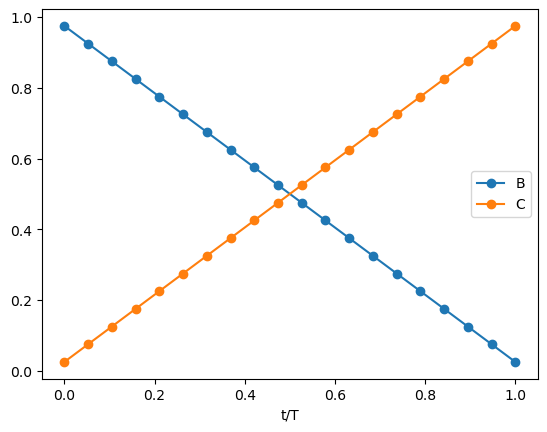

In [13]:
# Lets see it with an example
p = 20
# fill betas, gammas_singles and gammas_pairs
betas = list(np.linspace((1 - 0.5 / p), (0.5 / p), p))
gammas = betas[::-1]

fig, ax = plt.subplots()
ax.plot(np.linspace(0,1,p), betas, marker="o", label=r"B")
ax.plot(np.linspace(0,1,p), gammas, marker="o", label=r"C")
ax.set_xlabel("t/T")
# ax.set_ylabel("initial condition")
# ax.set_xticks(np.linspace(0,1,p))
ax.legend()


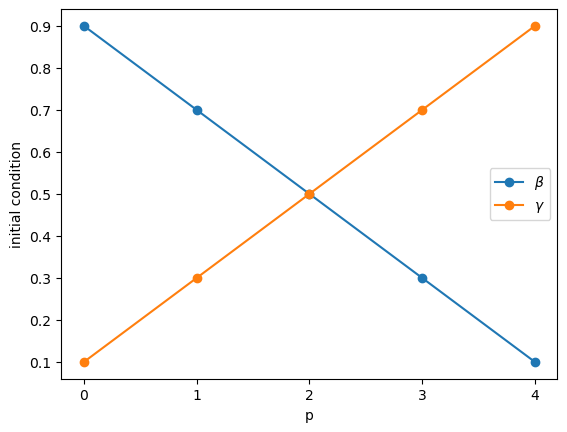

In [14]:
# Lets see it with an example
p = 5
# fill betas, gammas_singles and gammas_pairs
betas = list(np.linspace((1 - 0.5 / p), (0.5 / p), p))
gammas = betas[::-1]

fig, ax = plt.subplots()
ax.plot(range(p), betas, marker="o", label=r"$\beta$")
ax.plot(range(p), gammas, marker="o", label=r"$\gamma$")
ax.set_xlabel("p")
ax.set_ylabel("initial condition")
ax.set_xticks(range(p))
ax.legend()


In [15]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit import Aer
from scipy.optimize import minimize

ideal_backend = Aer.get_backend("qasm_simulator") # Simulator of the quantum computer

In [16]:
def qaoa_circuit(ising_Hamiltonian, p=1):
    """
    Return the parametric QAOA circuit 

    Parameters
    ----------
    ising_Hamiltonian: Sympy parametric function
        Cost Hamiltonian (Hc) of our problem.
    p: int
        Number of QAOA layers
    Returns
    -------
    qc: QuantumCircuit
        QAOA circuit for 

    """
    betas = ParameterVector(r"$\beta$", p) # Create a set of variables beta
    gammas = ParameterVector(r"$\gamma$", p) # Create a set of variables gamma

    ising_dict = ising_Hamiltonian.expand().as_coefficients_dict() # convert the hamiltonian into a dictionary
    num_qubits = len(ising_Hamiltonian.free_symbols) # Based on the variables 
    
    qc = QuantumCircuit(num_qubits) # Creating a quantum circuit
    
    # -------------------  Apply the initial layer of Hadamard gates to all qubits ------------------- 
    qc.h(range(num_qubits))
    # repeat p layers the circuit shown in Fig. 1
    for layer in range(p):
        # ------------------- Ising Hamiltonian single-qubit terms -----------------------
        for i in range(num_qubits): 
            if Symbol(f"z{i}") in ising_dict:
                wi = float(ising_dict[Symbol(f"z{i}")])
                qc.rz(2 * gammas[layer] * wi, i)
        qc.barrier()
        # ------------------- Ising Hamiltonian two-qubit terms -----------------------        
        for i in range(num_qubits): 
            for j in range(i+1, num_qubits):
                if Symbol(f"z{i}")* Symbol(f"z{j}") in ising_dict:
                    wij = float(ising_dict[Symbol(f"z{i}")*Symbol(f"z{j}")])
                    qc.rzz(2 * gammas[layer] * wij, i, j)
        qc.barrier()
        # ------------------- Mixer Hamiltonian ----------------------- 
        for i in range(num_qubits): 
            qc.rx(-2 * betas[layer], i)

    qc = qc.reverse_bits() #Because qiskit gives the bitstring solution in reversed order
    qc.measure_all()
    return qc

## 1.3 Optimization 

Once we define the QAOA circuit of the combinatorial optimization problem, the next step is to find values of $\beta$ and $\gamma$ that minimize the expectation value of the Ising Hamiltonian. Here, we use `qiskit` and `sympy` to minimize the `ising_hamiltonian`. In this case, we use the `COBYLA` optimization method with a maximum iteration equal to `max_iter=100`.

We will use the approximation ratio `r` to evaluate the performance of our model.
$$r = 1 - \frac{H(\beta,\gamma) - H_{max}}{H_{min} - H_{max}},$$
where $H_{min(max)}$ is the minimum (maximum) value the `ising_hamiltonian` can take. A value close to one indicates that our optimization is improving on average. 

Additionally, we can evaluate how well is doing our optimization in finding the optimal solution. In this case, we just need to sample enough times and evaluate how many times the optimal solution is found, and divide by the total number of samples.


In [17]:
def cost_func(parameters, circuit, ising_hamiltonian, Hmin, Hmax , callback, shots=1000, backend=Aer.get_backend("qasm_simulator")):
    """
    Return a cost function that depends of the QAOA circuit 

    Parameters
    ----------
    parameters : list
        gammas and betas values of the QAOA circuit.
    circuit : QuantumCircuit
        Qiskit quantum circuit of the QAOA.
    ising_hamiltonian : sympy Ising Hamiltonian formulation 
        Objective function of the problem 
    Hmin: float
        Minimum energy of the cost Hamiltonian
    Hmax: float
        Maximum energy of the cost Hamiltonian
    calllback: dict
        Dictionary where the information of each iteration is stored.
    shots : int, optional
        number of times the QAOA circuit is run. The default is 10.
    backend : Qiskit Backend, optional
        Simulator of the quantum computer. The default is Aer.get_backend("qasm_simulator").

    Returns
    -------
    float
        Cost of the evaluation of n string on the objective function 

    """
    cost = 0
    # running the QAOA circuit using qiskit 
    qc = circuit.copy()
    counts = backend.run(qc.assign_parameters(parameters=parameters), shots=shots).result().get_counts()
    # The qiskit's result is a dictionary with strings {0,1}^num_qubits as keys and values equal
    # to the frequency the bitstring is observed, e.g, counts = {"0101011": 5, "1101011":5}. This means for 10 shots 
    # of the qc circuit 5 of them give the bitstring "0101011"...
    for sample, n_counts in counts.items():
        feval = ising_hamiltonian.subs({Symbol(f"z{i}"):1 - 2*int(bi) for i, bi in enumerate(sample)}) #evaluate each bitstring on the cost function (Ising Hamiltonian)
        cost += (n_counts/shots) * float(feval) # Multiply the Ising Hamiltonian cost by the number of times the bitstring probability (samples/num_shots) in our previous example (5/10).
    # save the information
    callback["fx"].append(cost)
    callback["params"].append(parameters)
    callback["r"].append(1 - (cost - Hmin)/(Hmax - Hmin))
    print(f"cost: {round(cost,2)} | r: {round(callback['r'][-1],2)}")
    return cost 


In [18]:
p = 5 #Number of QAOA layers
qc = qaoa_circuit(ising_hamiltonian, p=p) # Generating the QAOA circuit


In [19]:
callback = {"fx":[], "params":[], "r":[]}
backend = ideal_backend # simulator of the quantum computer
shots = 1000 # Number of samples for each iteration of the QAOA circuit
seed = 123
np.random.seed(seed)
# Initialization
betas = list(np.linspace((1 - 0.5 / p), (0.5 / p), p))
gammas = betas[::-1] 
# optimization: minimization of the cost function 
sol = minimize(cost_func, x0 = betas + gammas, args=(qc, ising_hamiltonian, Hmin, Hmax, callback, shots, backend),
               method="COBYLA", options={"maxiter":200})
sol

cost: 68.92 | r: 0.83
cost: 62.71 | r: 0.84
cost: 87.29 | r: 0.79
cost: 53.68 | r: 0.86
cost: 65.39 | r: 0.84
cost: 69.08 | r: 0.83
cost: 62.86 | r: 0.84
cost: 60.94 | r: 0.85
cost: 55.8 | r: 0.86
cost: 57.76 | r: 0.85
cost: 54.3 | r: 0.86
cost: 59.74 | r: 0.85
cost: 60.42 | r: 0.85
cost: 87.71 | r: 0.78
cost: 80.55 | r: 0.8
cost: 55.36 | r: 0.86
cost: 61.15 | r: 0.84
cost: 77.44 | r: 0.81
cost: 62.76 | r: 0.84
cost: 78.68 | r: 0.81
cost: 61.91 | r: 0.84
cost: 65.81 | r: 0.83
cost: 70.57 | r: 0.82
cost: 76.64 | r: 0.81
cost: 88.29 | r: 0.78
cost: 53.36 | r: 0.86
cost: 64.3 | r: 0.84
cost: 55.48 | r: 0.86
cost: 65.65 | r: 0.83
cost: 101.49 | r: 0.75
cost: 66.45 | r: 0.83
cost: 73.55 | r: 0.82
cost: 53.81 | r: 0.86
cost: 63.14 | r: 0.84
cost: 85.02 | r: 0.79
cost: 56.76 | r: 0.85
cost: 50.22 | r: 0.87
cost: 67.64 | r: 0.83
cost: 53.34 | r: 0.86
cost: 62.63 | r: 0.84
cost: 60.41 | r: 0.85
cost: 57.81 | r: 0.85
cost: 57.11 | r: 0.85
cost: 56.92 | r: 0.85
cost: 83.32 | r: 0.79
cost: 58.72 |

     fun: 49.90800000000003
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 100
  status: 1
 success: True
       x: array([1.87407974, 0.63985845, 1.50277678, 0.33444113, 0.12377881,
       0.11316182, 0.31154422, 0.50668068, 0.74469778, 0.90183156])

In [20]:
parameters = sol.x
shots = 10000
#Run the QAOA circuit using the betas and gammas found
counts = backend.run(qc.assign_parameters(parameters=parameters), shots=shots).result().get_counts()
opt_res = {sol_str:counts[sol_str]} #probability of the optimal solution
print(f"Probability to find the optimal solution: {100*counts[sol_str]/shots}% | probability random guessing the optimal solution: {100*(1/2**len(items))}%")

Probability to find the optimal solution: 0.4% | probability random guessing the optimal solution: 3.125%


As you can see, our optimization does not produce the results we were expecting (increasing the probability of finding the optimal solution), instead the probability get worse compared just with random guessing over the full set of possible bitstrings. This is explained by two facts, first the slack variables reduce even more the probability of finding the optimal solution. Second, the optimization process is pointing in the direction of reducing the energy. From this point of view, the optimization can be seen as improving the probability of finding feasible solutions, but not to the optimal one. 

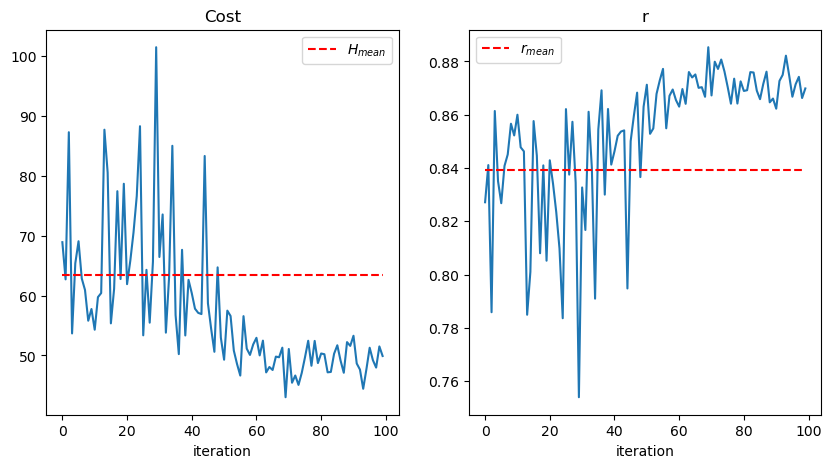

In [21]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(callback["fx"])
ax[0].plot(range(len(callback["fx"])), len(callback["fx"]) * [Hmean], linestyle="--", color="red", label="$H_{mean}$")
ax[1].plot(callback["r"])
ax[1].plot(range(len(callback["r"])), len(callback["r"]) * [1 - (Hmean-Hmin)/(Hmax - Hmin) ], linestyle="--", color="red", label="$r_{mean}$")
ax[0].set_title("Cost")
ax[1].set_title("r")
for i in range(2):
    ax[i].set_xlabel("iteration")
    ax[i].legend()

Text(0.5, 1.0, 'QAOA with optimized parameters: samples')

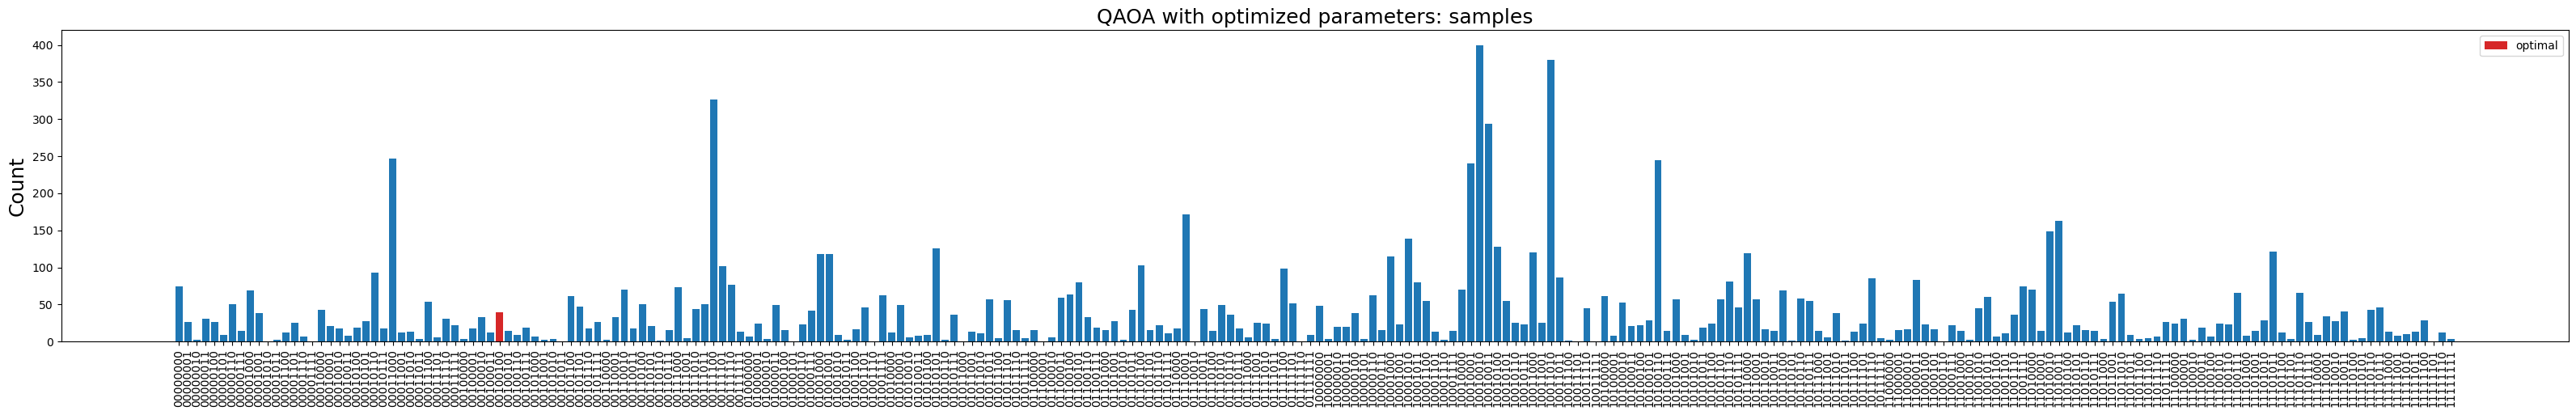

In [22]:
fig, ax = plt.subplots(figsize=(40,5))
ax.bar([int(k, 2) for k in counts.keys()], counts.values())
ax.bar([int(k, 2) for k in counts.keys() if k in opt_res], [v for k, v in counts.items() if k in opt_res], color="tab:red", label="optimal")
ax.set_xticks(range(2**len(f.free_symbols)))
ticks = ax.set_xticklabels([np.binary_repr(i, len(f.free_symbols)) for i in range(2**len(f.free_symbols))], rotation=90)
ax.set_ylabel("Count", fontsize=18)
ax.legend()
ax.set_title("QAOA with optimized parameters: samples", fontsize=18)

## 1.4 Conclusion

Well, we came this far to know that Knapsack problem is maybe not the best example if we try to improve the probability of getting the optimal solution. Even if we try to improve the probability of success for our optimal solution by increasing the number of layers, we will find the same issue over and over. It may be the case that simply Knapsack is not the right problem to fit into our QAOA algorithm. So your task for the following part will be to repeat the QAOA algorithm but for the [maximal independent set](https://en.wikipedia.org/wiki/Maximal_independent_set#:~:text=In%20graph%20theory%2C%20a%20maximal,to%20the%20independent%20set%20property).




# 2. MIS - Problem 

The Maximal Independent Set (MIS) problem asks to find the largest subset of vertices of a graph, such that no two vertices in the subset are adjacent. This subset is then called independent. Formally, for an undirected graph $G = (V,E)$, the problem formulation is: 

\begin{equation}\label{MIS_cost}
    \max \sum_{v \in V} x_v,\tag{12}
\end{equation}
subject to

\begin{equation}\label{MIS_inequality}
    x_u + x_v \leq 1 \qquad \forall (u, v) \in E, \tag{13}
\end{equation}
where the binary variable $x_v \in \{0,1\}$ determines whether a vertex is included in the subset or not, $V$ represent the vertices in the problem, and $E$ the edges. Applications of the MIS problem are, for example, employee work time scheduling and DNA sequencing. 

Use QAOA to find the optimal solution of the MIS for the following graph.

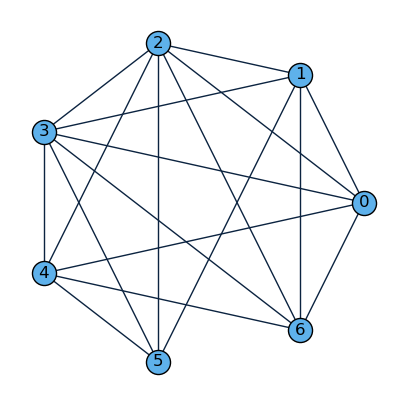

In [23]:
import networkx as nx
seed = 123
num_nodes = 7
edge_probability = 0.7
G = nx.erdos_renyi_graph(num_nodes, edge_probability, seed=seed)
pos = nx.circular_layout(G)
fig, ax = plt.subplots(figsize=(5,5))
nx.draw(G, with_labels=True, pos=pos, ax=ax, node_color="#5EB1EB", edge_color="#0B2340", edgecolors="black")

## 2.1 Exercise 1: Problem formulation

Using Eq.12 define the objective function using `sympy`.

In [24]:
from sympy import Symbol

E = G.edges #edges
V = G.nodes #nodes

x = {i: Symbol(f"x{i}") for i in range(num_nodes)}  # variables that represent the nodes
fx = 0
for i in range(num_nodes):
    fx -= x[i] # Your code here
print("f(x) =", fx)


f(x) = -x0 - x1 - x2 - x3 - x4 - x5 - x6


## 2.2 Exercise 2: Constraints Formulation

In general, inequality constraints require slack variables. However, Eq. 12 is a particular case because it can be represented by the multiplication of the variables in play. For example, imagine node 1 and node 2 share an edge, then $x_1 + x_2 \le 1$, we can represent whether this constraint is fulfilled or not with the penalization term $\lambda x_1x_2$. Note that only when $x_1=1$ and $x_2=1$, do we have a penalization term, otherwise the penalization is equal to zero. Additionally, consider the penalization term for this constraint $\lambda=2$ (of course you can play around with this value to improve the probability of finding the optimal solution 😉).

In [25]:
lambd = 2
constraints = 0
for i, j in G.edges:
    constraints += lambd * x[i] * x[j] # Your code here
print("penalization =", constraints)

qubo = fx + constraints

penalization = 2*x0*x1 + 2*x0*x2 + 2*x0*x3 + 2*x0*x4 + 2*x0*x6 + 2*x1*x2 + 2*x1*x3 + 2*x1*x5 + 2*x1*x6 + 2*x2*x3 + 2*x2*x4 + 2*x2*x5 + 2*x2*x6 + 2*x3*x4 + 2*x3*x5 + 2*x3*x6 + 2*x4*x5 + 2*x4*x6


## 2.3 Exercise 3: Brute force solution

From all possible solutions, find the ones with the lowest cost, maximum cost and the average cost. Note, that in this case, different solutions can have the same cost. Save in `min_strings` the bitstrings with the lowest cost and in `cost` all the possible cost of the qubo.

In [26]:
cost = []
min_strings = []
min_cost = 1e6
for i in range(2**num_nodes):
    string = np.binary_repr(i, num_nodes)
    cost.append(float(qubo.subs({x[i]:s for i, s in zip(x, string)}))) # -----------   your code here
    if cost[-1] < min_cost:
        min_cost = cost[-1]
        min_strings = [string] # -----------   your code here
    elif cost[-1] == min_cost:
        min_strings.append(string) # -----------   your code here

Hmin = min(cost)
Hmax = max(cost)
Hmean = np.mean(cost)

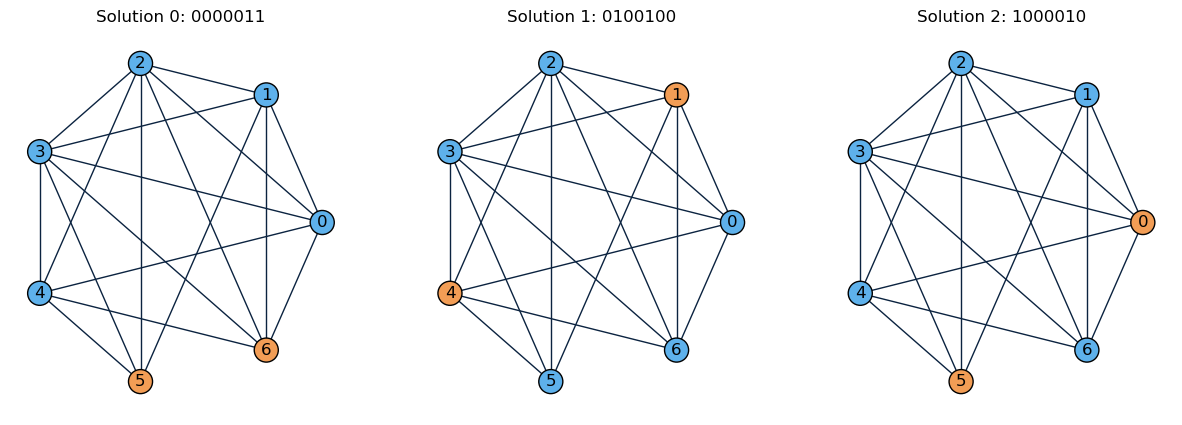

In [27]:
fig, ax = plt.subplots(1, len(min_strings), figsize=(5*len(min_strings), 5))
colors = {'0':"#5EB1EB", '1':"#F29D55"}
for i, string in enumerate(min_strings):
    if len(min_strings) > 1:
        axi = ax[i]
    else:
        axi = ax
    nx.draw(G, pos=pos, ax=axi , with_labels=True, node_color=[colors[i] for i in string], edge_color="#0B2340", edgecolors="black")
    axi.set_title(f"Solution {i}: {string}")

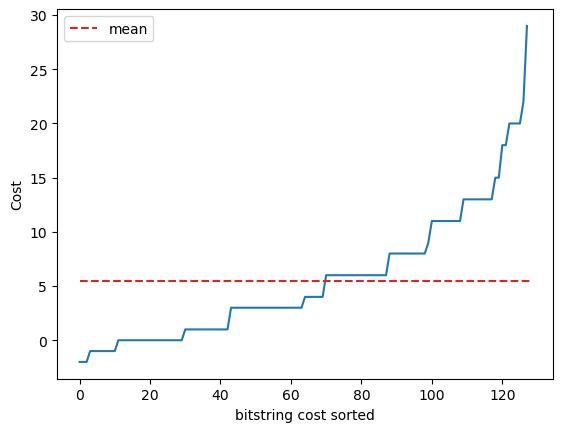

In [28]:
fig, ax = plt.subplots()
ax.plot(sorted(cost))
ax.plot([0, len(cost)],2*[Hmean], color="tab:red", linestyle="--", label="mean")
ax.set_xlabel("bitstring cost sorted")
ax.set_ylabel("Cost")
ax.legend()

## 2.4 Exercise 4: Ising Hamiltonian

Transform the `QUBO` formulation into the `Ising Hamiltonian` as in section 1.1

In [29]:
new_vars = {xi:(1 - Symbol(f"z{i}"))/2 for i, xi in x.items()}

ising_hamiltonian = qubo.subs(new_vars) # your code here


## 2.5 Exercise 5: QAOA circuit

Using the `ising_hamiltonian` of the previous step, construct the qaoa circuit using the `qaoa_circuit` function from above.

In [30]:
p = 5
qc = qaoa_circuit(ising_hamiltonian, p=p) # Your code here
# qc.draw()

## 2.6 Exercise 6: Optimization

In [31]:
callback = {"fx":[], "params":[], "r":[]}

seed = 123
np.random.seed(seed)
backend = ideal_backend
shots = 1000
# Initialization
betas = list(np.linspace((1 - 0.5 / p), (0.5 / p), p))
gammas = betas[::-1]
# optimization: minimization
sol = minimize(cost_func, x0 = betas + gammas, args=(qc, ising_hamiltonian, Hmin, Hmax, callback, shots, backend),
               method="COBYLA", options={"maxiter":100}) # ---- your code here
sol

cost: -0.5 | r: 0.95
cost: 0.94 | r: 0.91
cost: 9.4 | r: 0.63
cost: 13.73 | r: 0.49
cost: 11.28 | r: 0.57
cost: 8.67 | r: 0.66
cost: 6.73 | r: 0.72
cost: 4.05 | r: 0.8
cost: 3.3 | r: 0.83
cost: 1.33 | r: 0.89
cost: 0.14 | r: 0.93
cost: 10.18 | r: 0.61
cost: 0.25 | r: 0.93
cost: 0.8 | r: 0.91
cost: -0.2 | r: 0.94
cost: 1.66 | r: 0.88
cost: 0.28 | r: 0.93
cost: -0.39 | r: 0.95
cost: 0.47 | r: 0.92
cost: 1.14 | r: 0.9
cost: -0.4 | r: 0.95
cost: 0.46 | r: 0.92
cost: -0.42 | r: 0.95
cost: -0.56 | r: 0.95
cost: 0.52 | r: 0.92
cost: 0.76 | r: 0.91
cost: -0.7 | r: 0.96
cost: -0.9 | r: 0.96
cost: -0.39 | r: 0.95
cost: -0.67 | r: 0.96
cost: -0.54 | r: 0.95
cost: -0.71 | r: 0.96
cost: -0.61 | r: 0.96
cost: -0.7 | r: 0.96
cost: -0.57 | r: 0.95
cost: -0.69 | r: 0.96
cost: -0.23 | r: 0.94
cost: -0.71 | r: 0.96
cost: -0.73 | r: 0.96
cost: -0.76 | r: 0.96
cost: -0.77 | r: 0.96
cost: -0.72 | r: 0.96
cost: -0.79 | r: 0.96
cost: -0.81 | r: 0.96
cost: -0.71 | r: 0.96
cost: -0.8 | r: 0.96
cost: -0.84 | r: 

     fun: -0.7969999999999999
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 99
  status: 1
 success: True
       x: array([0.89125079, 0.62420576, 0.30297574, 0.17899392, 0.05653888,
       0.08360836, 0.344622  , 0.39105194, 0.66645395, 0.99463147])

Text(0, 0.5, 'r')

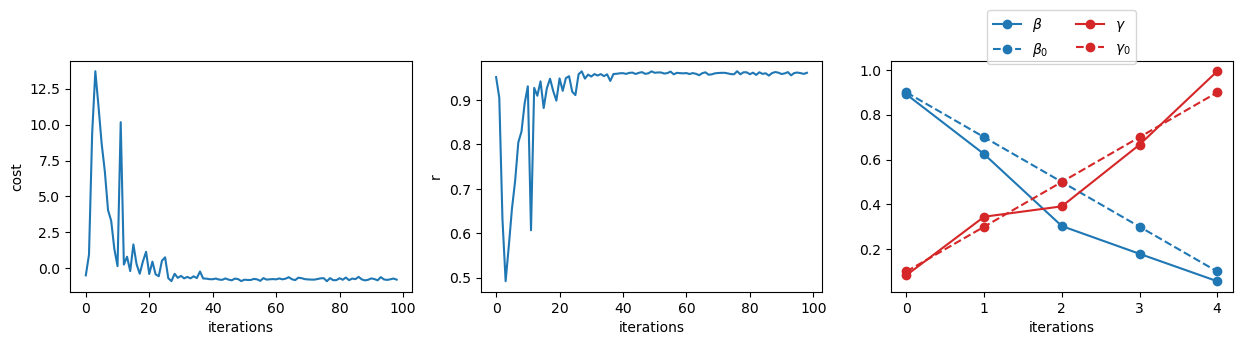

In [32]:
fig, ax = plt.subplots(1,3, figsize=(15,3))
ax[0].plot(callback["fx"])
ax[1].plot(callback["r"])
ax[2].plot(sol.x[:p], label=r"$\beta$", color="tab:blue", marker="o")
ax[2].plot(betas, label=r"$\beta_0$", color="tab:blue", linestyle="--", marker="o")
ax[2].plot(sol.x[p:], label=r"$\gamma$", color="tab:red", marker="o")
ax[2].plot(gammas, label=r"$\gamma_0$", color="tab:red", linestyle="--", marker="o")

ax[2].legend(loc="upper center", bbox_to_anchor=(0.5, 1.25), ncol=2)
for i in range(3):
    ax[i].set_xlabel("iterations")
ax[0].set_ylabel("cost")
ax[1].set_ylabel("r")

## 2.7 Exercise 7: Finding the probability of getting the optimal solutions

Find the probability of the optimal solutions for `1000 shots` and the optimal $\beta$'s and $\gamma$'s from the previous step.

In [33]:
parameters = sol.x
shots = 1000
# Run the QAOA circuit using the betas and gammas found
counts = backend.run(qc.assign_parameters(parameters=sol.x), shots=shots).result().get_counts() # -------- Your code here
opt_res = {string:100*counts[string]/shots for string in min_strings if string in counts.keys()} #probability of the optimal solution
print(f"Probability to find the optimal solution: {sum(list(opt_res.values()))}% | probability random guessing the optimal solution: {100*(1/2**num_nodes)}%")

Probability to find the optimal solution: 27.0% | probability random guessing the optimal solution: 0.78125%


Text(0.5, 1.0, 'QAOA with optimized parameters: samples')

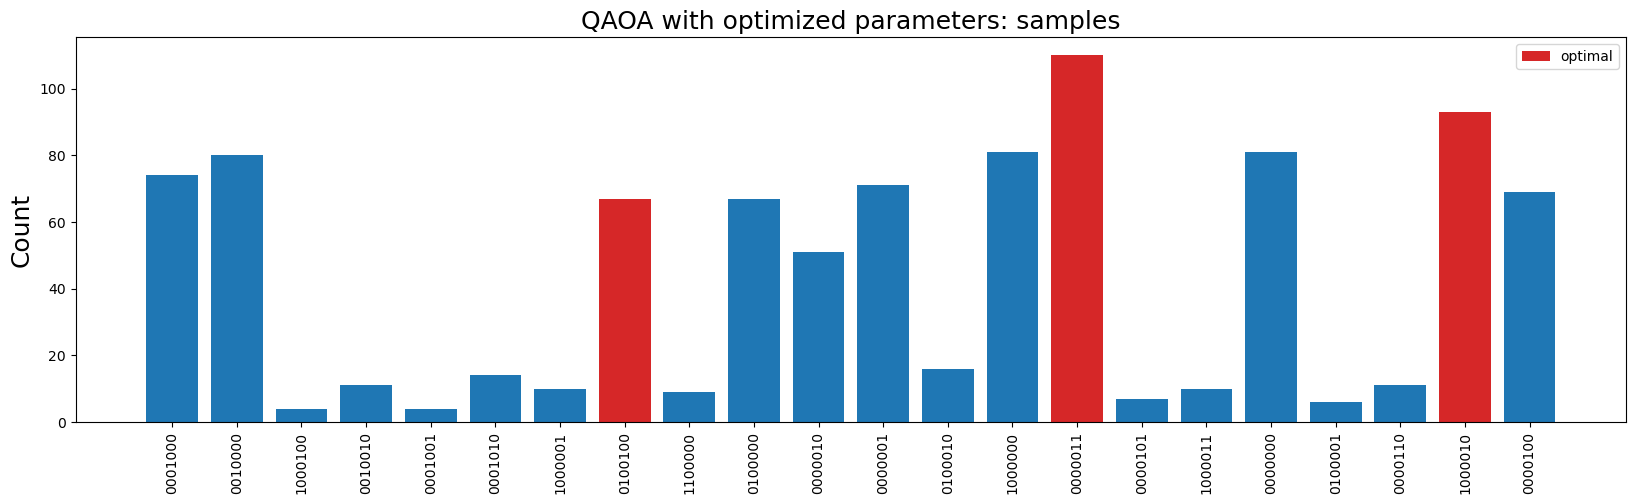

In [34]:
fig, ax = plt.subplots(figsize=(20,5))
large_counts = {k: v for k, v in counts.items() if v > 3}
ax.bar(range(len(large_counts)), large_counts.values())
ax.bar([i for i, k in enumerate(large_counts.keys()) if k in min_strings], [v for k, v in large_counts.items() if k in min_strings], color="tab:red", label="optimal")
ax.set_xticks(range(len(large_counts)))
ticks = ax.set_xticklabels(large_counts.keys(), rotation=90)
ax.set_ylabel("Count", fontsize=18)
ax.legend()
ax.set_title("QAOA with optimized parameters: samples", fontsize=18)

## 2.9 Exercise 8: Implement the protocol on a Fake Backend

The results of the MIS problem are really nice, we were able to increase the chances of getting the optimal solution from $0.78%$ to $39$%! This is a nice improvement, but what happens if we want to use one of the available devices, for example, one of the IBM quantum computing devices? Let's see how the probability of finding the optimal solution using a [Fake backend](https://qiskit.org/documentation/apidoc/providers_fake_provider.html) (a simulator that mimics the characteristics of the real device).

In [35]:
from qiskit.providers.fake_provider import FakeJakartaV2
from qiskit import transpile

fake_jakarta = FakeJakartaV2() # emulator of a real quantum device

shots = 1000
# Run the QAOA circuit using the betas and gammas found
circ = qc.assign_parameters(parameters=sol.x)
circ = transpile(circ, fake_jakarta) # The transpailation converts your circuit into the default set of gates and connectivity of your device
counts = fake_jakarta.run(circ, shots=shots).result().get_counts() # -------- Your code here

opt_res = {string:100*counts[string]/shots for string in min_strings if string in counts.keys()} #probability of the optimal solution
print(f"Probability to find the optimal solution: {sum(list(opt_res.values()))}% | probability random guessing the optimal solution: {100*(1/2**num_nodes)}%")

Probability to find the optimal solution: 3.9% | probability random guessing the optimal solution: 0.78125%


## 2.10 Final Exercise: Improving the outcome of the Fake backend

Now, you are free to try different strategies to improve the performance of `fake_jakarta` on this problem. At the end of this week, we will announce the team with the highest probability for the optimal solution of this problem using `fake_jakarta`. Can you improve it by using more layers? What about a better initialization? a [different cost function](https://arxiv.org/pdf/1907.04769.pdf)?, [Error mitigation](https://arxiv.org/pdf/2307.14427.pdf)? only you will know by trying different options... Let's see who comes up with the more ingenious solutions. 😁